In [170]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import pgeocode
import datetime
import joblib
import pickle
warnings.filterwarnings("ignore")
%matplotlib inline

# 1) Data Formatting

## Open Excel File in DataFrame

In [2]:
df = pd.read_excel('CarData.xlsx')

In [3]:
data = df.copy()

In [4]:
print(len(data.index))

62962


## Remove Incorrect Records

In [5]:
def find_incorrect_records(make, trim):
  if make in trim:
    return False
  return True

In [6]:
for i, row in data.iterrows():
  if find_incorrect_records(row['Make'], row['Trim']):
    data = data.drop(i)

## Remove Duplicates

In [7]:
data = data.drop_duplicates(subset=['VIN'])

In [8]:
data = data.drop('VIN', axis=1)

In [9]:
print(len(data.index))

61379


## Parse Column Information

In [10]:
def parse_year(car_string):
  match = re.search(r'\b(19|20)\d{2}\b', car_string)
  return int(match.group(0)) if match else None

def parse_trim(car_string, make, model):
  if make in car_string:
    trim = car_string.split(make, 1)[1]
    if model in trim:
      trim = trim.split(model, 1)[1]
      trim = trim.replace('for Sale', '')
      return str(trim.strip())
    else:
      return None
  else:
    return None

def parse_zip_code(location):
  if type(location) == str:
    zip = location.split(' ')[-1]
    return str(zip)
  return None

def parse_price(price):
  if type(price) == str:
    num = price.replace('$','')
    num = num.replace(',','')
    return int(num)
  return None

def parse_miles(miles):
  if type(miles) == str:
    mileage = miles.replace(' miles', '')
    mileage = mileage.replace(',','')
    return int(mileage.strip())
  return None

def parse_engine_size(engine):
  if type(engine) == str and '-cylinder' in engine:
    size = engine.replace('-cylinder','')
    return int(size.strip())
  return None

def parse_seats(seats):
  if type(seats) == str and 'seater' in seats:
    seats = seats.replace('seater','')
    return int(seats.strip())
  return None

In [11]:
data['Year'] = data['Year'].apply(parse_year)

data['Trim'] = data.apply(lambda row: parse_trim(row['Trim'], row['Make'], row['Model']), axis=1)

data['Location'] = data['Location'].apply(parse_zip_code)

data['Price'] = data['Price'].apply(parse_price)

data['Mileage'] = data['Mileage'].apply(parse_miles)

data['Engine_Size'] = data['Engine_Size'].apply(parse_engine_size)

data['Seats'] = data['Seats'].apply(parse_seats)

data.loc[data['Fuel_Type'] == 'Electric', 'Engine_Size'] = 0

data.loc[data['Fuel_Type'] == 'Natural Gas', 'Fuel_Type'] = 'Gas'

data = data.drop(columns=['Seats'])

## Remove Some Null Values

In [12]:
data.sample(1)

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
3494,Audi,S8,2024,4.0T quattro,07094,141805.0,10.0,Automatic,Mythos Black Metallic,8.0,Gas,18.0,AWD


In [13]:
print(len(data.index))
data = data.drop(data[data['Trim'].isna()].index)
data = data.drop(data[data['Trim']==''].index)
print(len(data.index))
print(data.isna().sum().sum())

61379
59749
28566


## Helper Functions

In [14]:
def median_value(feature, model, year, trim, data, window=2):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
    median_val = relevant_data[feature].median()
    return median_val if not pd.isna(median_val) else np.nan

def most_common_value(feature, model, year, trim, data, window=2):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
    common_value = relevant_data[feature].mode()
    return common_value[0] if not common_value.empty else np.nan

def fill_nan_with_median(feature, row, window):
    if pd.isna(row[feature]):
        return median_value(feature, row['Model'], row['Year'], row['Trim'], data, window)
    return row[feature]

def fill_nan_with_mode(feature, row, window):
    if pd.isna(row[feature]):
        return most_common_value(feature, row['Model'], row['Year'], row['Trim'], data, window)
    return row[feature]

## Replace Values

In [15]:
print("Engine Size: ", data['Engine_Size'].unique())

Engine Size:  [ 6.  4.  0. nan  8. 12.  5. 10.  3. 16.]


In [16]:
print(data['Engine_Size'].isna().sum())
data['Engine_Size'] = data.apply(lambda row: fill_nan_with_median('Engine_Size', row, 2), axis=1)
print(data['Engine_Size'].isna().sum())

758
624


In [17]:
print("Fuel Type: ", data['Fuel_Type'].unique())

Fuel Type:  ['Gas' 'Hybrid' 'Electric' 'Plug-in Hybrid' 'Diesel' 'Flex fuel' nan]


In [18]:
print(data['Fuel_Type'].isna().sum())
data['Fuel_Type'] = data.apply(lambda row: fill_nan_with_mode('Fuel_Type', row, 5), axis=1)
print(data['Fuel_Type'].isna().sum())

538
424


In [19]:
print("Transmission: ", data['Transmission'].unique())

Transmission:  ['Automatic' 'Manual' 'CVT' 'Red' nan]


In [20]:
data = data[data['Transmission'] != 'Red']
print(data['Transmission'].isna().sum())
data['Transmission'] = data.apply(lambda row: fill_nan_with_mode('Transmission', row, 5), axis=1)
print(data['Transmission'].isna().sum())

1418
201


In [21]:
print("Gas Mileage: ", data['Gas_Mileage'].unique())

Gas Mileage:  [ 20.  21.  22.  28.  29.  25.  24.  32.  33.  30.  18.  19.  17.  nan
  23.  15.  27.  26.  87.  77.  13.  14.  16.  12.  34.  83.  31.  68.
  54.  78.  74.  79.  85.  82.  75.  95.  93. 100.  61.  50.  60.  81.
  73.  11.  47.  10.   9.  46.  67.  36.  71.  62.  65.  64. 124. 117.
 113. 111. 118.  96. 109. 120.  91. 105.  90.  76.  69.  86.  56.  89.
  88.  92. 115. 119.  35. 108.  98. 106.  94.  84.  44.  51. 112. 116.
  40.  41.  39. 102.  70.  66. 107.  97. 103.  42.  37.  99.  53.  48.
  43.  45. 110.  38.  52. 114. 121. 127.  55.  58.  59.  80.  49. 101.
 104. 123. 125. 122.  57.  63.]


In [22]:
print(data['Gas_Mileage'].isna().sum())
data['Gas_Mileage'] = data.apply(lambda row: fill_nan_with_mode('Gas_Mileage', row, 4), axis=1)
print(data['Gas_Mileage'].isna().sum())

12800
8262


In [23]:
print("Drive Type: ", data['Drive_Type'].unique())

Drive Type:  ['FWD' 'AWD' 'RWD' 'FOUR_WD' nan '4 seater' 'FOUR_X_FOUR' '7 seater'
 'FOUR_X_TWO' 'JTJBC1BA4D2050855']


In [24]:
data = data.drop(data[data['Drive_Type'] == 'JTJBC1BA4D2050855'].index)
data = data.drop(data[data['Drive_Type'] == '4 seater'].index)
data = data.drop(data[data['Drive_Type'] == '7 seater'].index)
replacements = {
    'FOUR_WD': 'AWD',
    'FOUR_X_FOUR': 'AWD',
    'FOUR_X_TWO': 'RWD'
}

data['Drive_Type'] = data['Drive_Type'].replace(replacements)
print(data['Drive_Type'].isna().sum())
data['Drive_Type'] = data.apply(lambda row: fill_nan_with_mode('Drive_Type', row, 4), axis=1)
print(data['Drive_Type'].isna().sum())

704
533


In [25]:
def average_mileage(model, year, data, window=1):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
    avg_mlg = relevant_data['Mileage'].mean()
    if pd.isna(avg_mlg):
        return np.nan
    noise = avg_mlg*0.05
    return np.random.normal(avg_mlg, noise)

def fill_nan_with_miles(row):
  if pd.isna(row['Mileage']):
    return average_mileage(row['Model'], row['Year'], data)
  return row['Mileage']

In [26]:
data = data.dropna(subset=['Mileage'])

## Fixing Incorrect Colors

In [27]:
def is_number(s):
    s = str(s)
    return not s.isdigit()

def remove_square_brackets(s):
    s = str(s)
    return re.sub(r'\[.*?\]', '', s).strip()

In [28]:
mask = data['Color'].apply(is_number)
data = data[mask]
data = data[data['Color']!='--']
data['Color'] = data['Color'].apply(remove_square_brackets)

## Removing Final Null/Incorrect Values

In [29]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
46785,MINI,Cooper,2009,Base,08094,7900.0,42599.0,Automatic,Red,4.0,Gas,NaN,FWD


In [30]:
print("Price: ", data['Price'].isna().sum())
print("Mileage: ", data['Mileage'].isna().sum())
print("Transmission: ", data['Transmission'].isna().sum())
print("Color: ", data['Color'].isna().sum())
print("Engine_Size: ", data['Engine_Size'].isna().sum())
print("Fuel_Type: ", data['Fuel_Type'].isna().sum())
print("Gas Mileage: ", data['Gas_Mileage'].isna().sum())
print("Drive_Type: ", data['Drive_Type'].isna().sum())
print(data.isna().sum().sum())

Price:  5489
Mileage:  0
Transmission:  186
Color:  0
Engine_Size:  540
Fuel_Type:  380
Gas Mileage:  7478
Drive_Type:  460
14863


In [31]:
print(len(data.index))
data = data.dropna()
print(len(data.index))

56901
44689


In [32]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
2290,Audi,Q4 e-tron Sportback,2024,quattro Premium Plus 55,01960,65305.0,10.0,Automatic,Mythos Black Metallic,0.0,Electric,100.0,AWD


## Add Coordinates From Zip Code

In [33]:
nomi = pgeocode.Nominatim('us')


latitudes = []
longitudes = []

for zip_code in data['Location']:
    location = nomi.query_postal_code(zip_code)
    latitudes.append(location.latitude if location is not None else None)
    longitudes.append(location.longitude if location is not None else None)

data['Latitude'] = latitudes
data['Longitude'] = longitudes
data['Latitude'] = data['Latitude']
data['Longitude'] = data['Longitude']

In [59]:
data = data.drop(columns=['Location'])
data = data.dropna(subset=['Latitude','Longitude'])

## Replace Year Column

In [35]:
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year'].astype(int)
data = data.drop(columns='Year')
data = data[data['Age']!=-1]

## Format Dataframe

In [36]:
price = data.pop('Price')
data.insert(len(data.columns), 'Price', price)
age = data.pop('Age')
data.insert(2, 'Age', age)

In [37]:
data.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
25529,Honda,Ridgeline,4,RTL,42575.0,Automatic,Gray,6.0,Gas,21.0,AWD,40.6205,-73.9239,28888.0


# 2) Exploratory Data Analysis

In [ ]:
# Find the total number of cars per manufacturer in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data['Make'])
plt.title("Manufacturer Distribution")
plt.show()

In [ ]:
# Find the number of cars made in each year in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Age, palette='viridis')
plt.title("Year Distribution")
plt.show()

In [ ]:
# Number of cars per transmission type
plt.figure(figsize=(20, 15))
sns.countplot(x=data.Transmission, palette='Paired')
plt.title("Transmission Distribution")
plt.show()

In [ ]:
# unique elements in data
data.nunique()

In [ ]:
# fuel type distribution
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Fuel_Type.sort_values(ascending=False), palette='Dark2')


In [ ]:
# Group rows by make
data.groupby('Make')[['Engine_Size','Gas_Mileage', 'Price']].agg(['min','max','mean','median'])

In [ ]:
# average price by year
plt.figure(figsize=(20, 10))
data.groupby('Age')['Price'].mean().plot(kind='bar',color='g')
plt.title('Average Price by Year')
plt.show()

In [ ]:
plt.figure(figsize = (10, 10))
data.groupby('Transmission')['Price'].mean().plot(kind = 'bar', color = 'y')
plt.title("Average Price by Transmission", fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
data.groupby(['Make'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'black')
plt.title("Average Price per Manufacturer", fontsize = 20)
plt.show()

In [ ]:
# Group by Drive Type
plt.figure(figsize = (20, 15))
data.groupby(['Drive_Type'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'orange')

In [ ]:
sns.scatterplot(x='Engine_Size',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
# Boxplot of MPG
sns.boxplot(x='Gas_Mileage', data=data,color='r')

In [ ]:
sns.scatterplot(x='Fuel_Type',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
numeric_columns = ['Age', 'Mileage', 'Engine_Size', 'Price']
heatmap_data = data[numeric_columns].corr()
sns.heatmap(heatmap_data, annot=True, cmap='BuPu')

In [ ]:
# Gas Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Gas_Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Gas Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
# Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Age')['Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
data.info()

# 3) Data Manipulation

In [152]:
print(len(data.index))

43935


In [153]:
frame = data.copy()

In [154]:
frame.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
60623,Volkswagen,Jetta,5,SE,79781.0,Automatic,Gray,4.0,Gas,34.0,FWD,40.8601,-74.1283,12995.0


## Split the Data

In [155]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [156]:
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (35148, 13)
The size of the output train data is: (35148,)
The size of the input test data is: (8787, 13)
The size of the output test data is: (8787,)


In [157]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
42438,Mazda,CX-90,0,3.3 Turbo Premium,2221.0,Automatic,Machine Gray Metallic,6.0,Gas,25.0,AWD,40.2458,-74.2768


## Target Encoding

In [158]:
make_encoder = TargetEncoder(cols='Make')
make_encoder.fit(X_train['Make'], y_train.to_frame()['Price'])
X_train['Make'] = make_encoder.transform(X_train['Make'])
X_test['Make'] = make_encoder.transform(X_test['Make'])

In [159]:
model_encoder = TargetEncoder(cols='Model')
model_encoder.fit(X_train['Model'], y_train.to_frame()['Price'])
X_train['Model'] = model_encoder.transform(X_train['Model'])
X_test['Model'] = model_encoder.transform(X_test['Model'])

In [160]:
trim_encoder = TargetEncoder(cols='Trim')
trim_encoder.fit(X_train['Trim'], y_train.to_frame()['Price'])
X_train['Trim'] = trim_encoder.transform(X_train['Trim'])
X_test['Trim'] = trim_encoder.transform(X_test['Trim'])

In [161]:
color_encoder = TargetEncoder(cols='Color')
color_encoder.fit(X_train['Color'], y_train.to_frame()['Price'])
X_train['Color'] = color_encoder.transform(X_train['Color'])
X_test['Color'] = color_encoder.transform(X_test['Color'])

## One Hot Encoding

In [162]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_train = encoder.transform(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_test = encoder.transform(X_test[['Transmission', 'Fuel_Type', 'Drive_Type']])

In [163]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)
X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)

## Standardization/Normalization

In [164]:
X_train.sample()
cols_to_scale = ['Age', 'Mileage', 'Engine_Size', 'Gas_Mileage', 'Latitude', 'Longitude']

In [165]:
# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [166]:
X_train.shape

(35148, 22)

# 4a) Machine Learning Analysis

In [73]:
mse = []
mae = []
mape = []

In [74]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Model Performance')
    print('Mean Absolute Error (MAE): {:0.4f}'.format(mae))
    print('Mean Absolute Percentage Error (MAPE): {:0.2f}'.format(mape))
    return mape

## K-Neighbors Regressor

In [75]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(knn, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 6070.0934
Mean Absolute Percentage Error (MAPE): 0.25


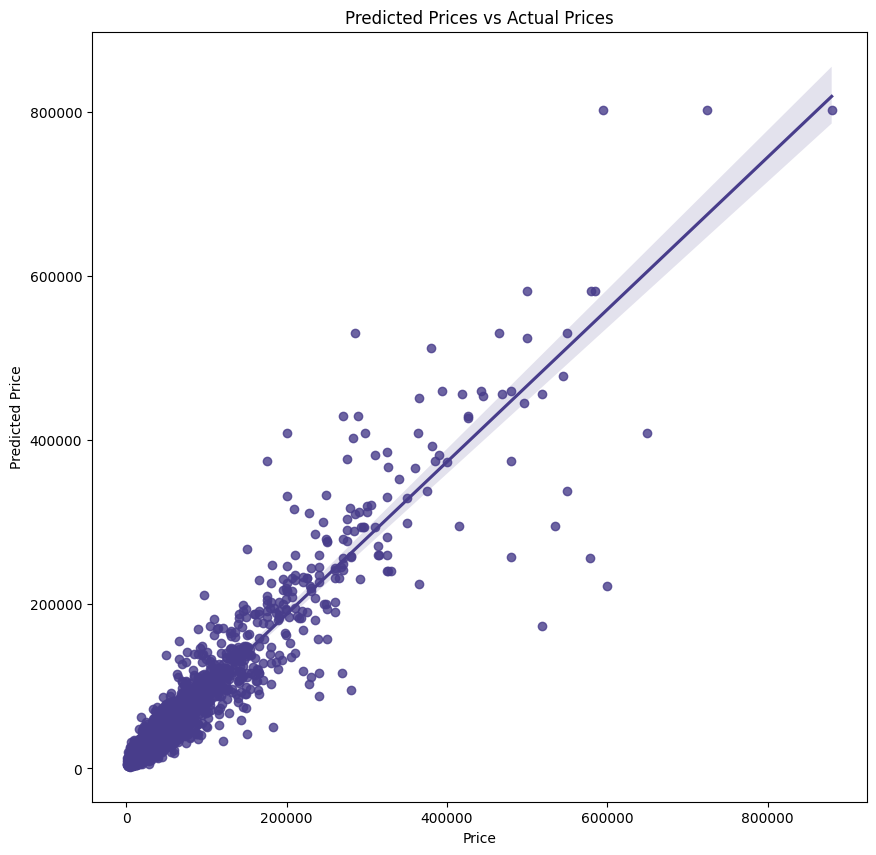

In [76]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkslateblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## PLS Regression

In [77]:
pls = PLSRegression()
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(pls, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 12616.1523
Mean Absolute Percentage Error (MAPE): 0.67


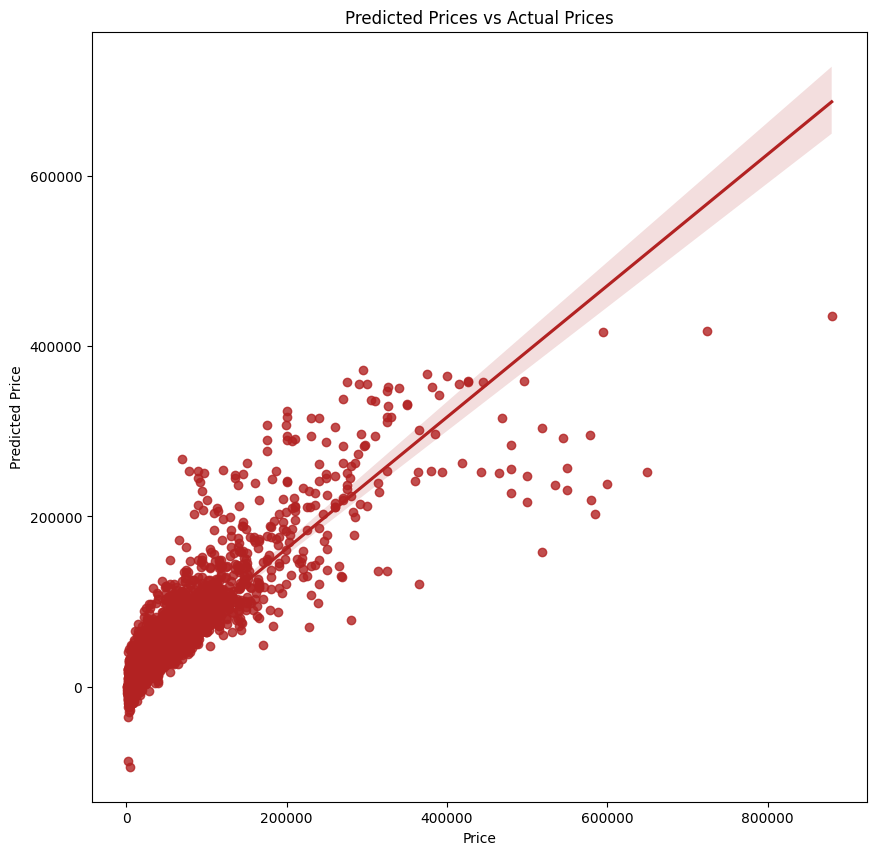

In [78]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='firebrick', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Decision Tree Regressor

In [79]:
dt = DecisionTreeRegressor(splitter='random', random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(dt, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 5189.0035
Mean Absolute Percentage Error (MAPE): 0.20


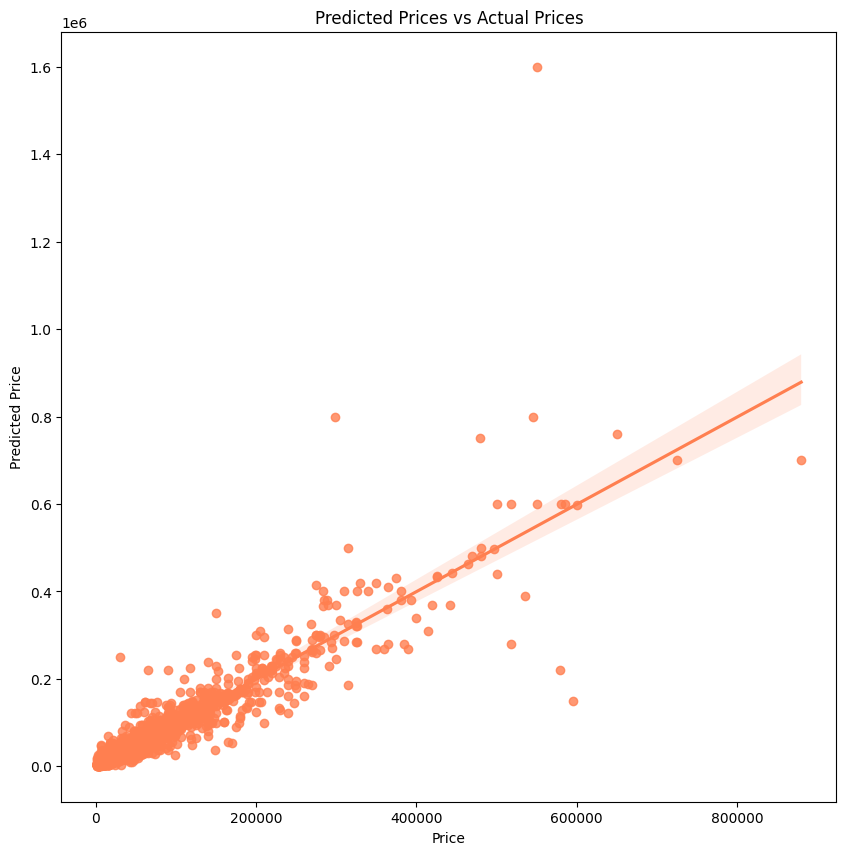

In [80]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Random Forest Regressor

In [91]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(rf, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 3629.2947
Mean Absolute Percentage Error (MAPE): 0.15


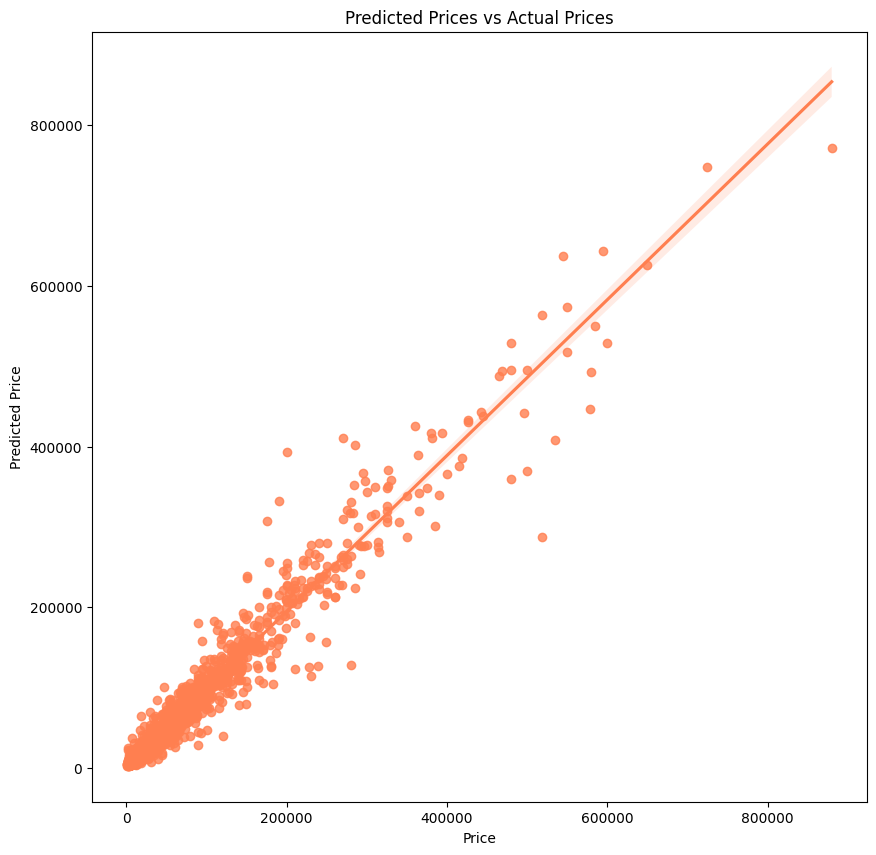

In [92]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Gradient Boosting Regressor

In [83]:
gb = GradientBoostingRegressor(random_state=1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(gb, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 6004.7271
Mean Absolute Percentage Error (MAPE): 0.23


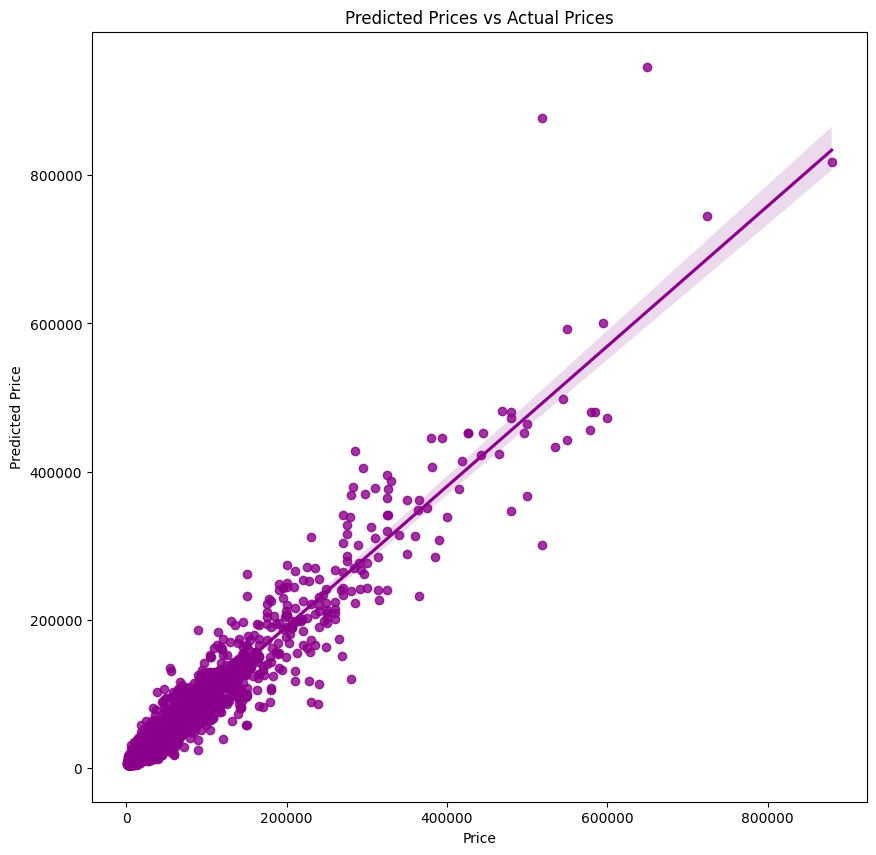

In [84]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkmagenta', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## MLP Regressor

In [85]:
mlp = MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='adam', learning_rate='adaptive')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))
mape.append(evaluate(mlp, X_test, y_test))

Model Performance
Mean Absolute Error (MAE): 7727.7702
Mean Absolute Percentage Error (MAPE): 0.27


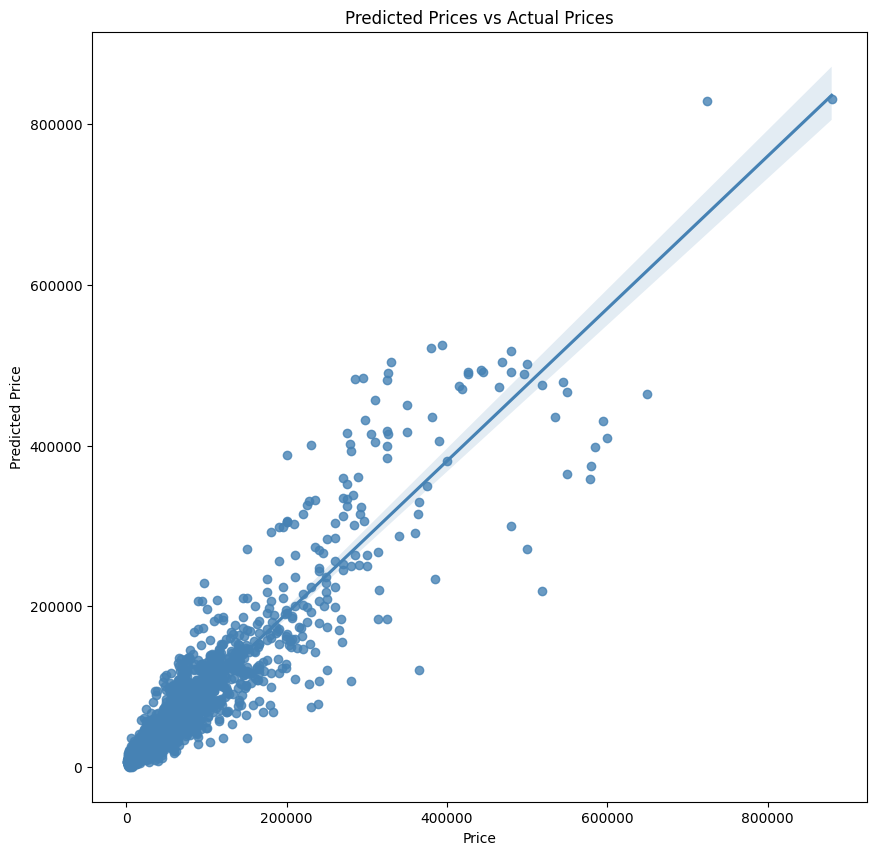

In [86]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='steelblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Dataframe of Machine Learning Models

In [87]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse, 'Mean Absolute Percent Error':mape}
model_dataframe = pd.DataFrame(models)

In [88]:
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error,Mean Absolute Percent Error
0,K Nearest Regressor,6070,229594687,0.252385
1,PLS Regression,12616,569829559,0.673520
2,Decision Tree Regressor,5189,357232254,0.202716
3,Random Forest Regressor,3629,91795974,0.147006
4,Gradient Boosting Regressor,6004,173017391,0.233988
5,MLP Regressor,7727,291716469,0.271169


## Barplot of Machine Learning Models

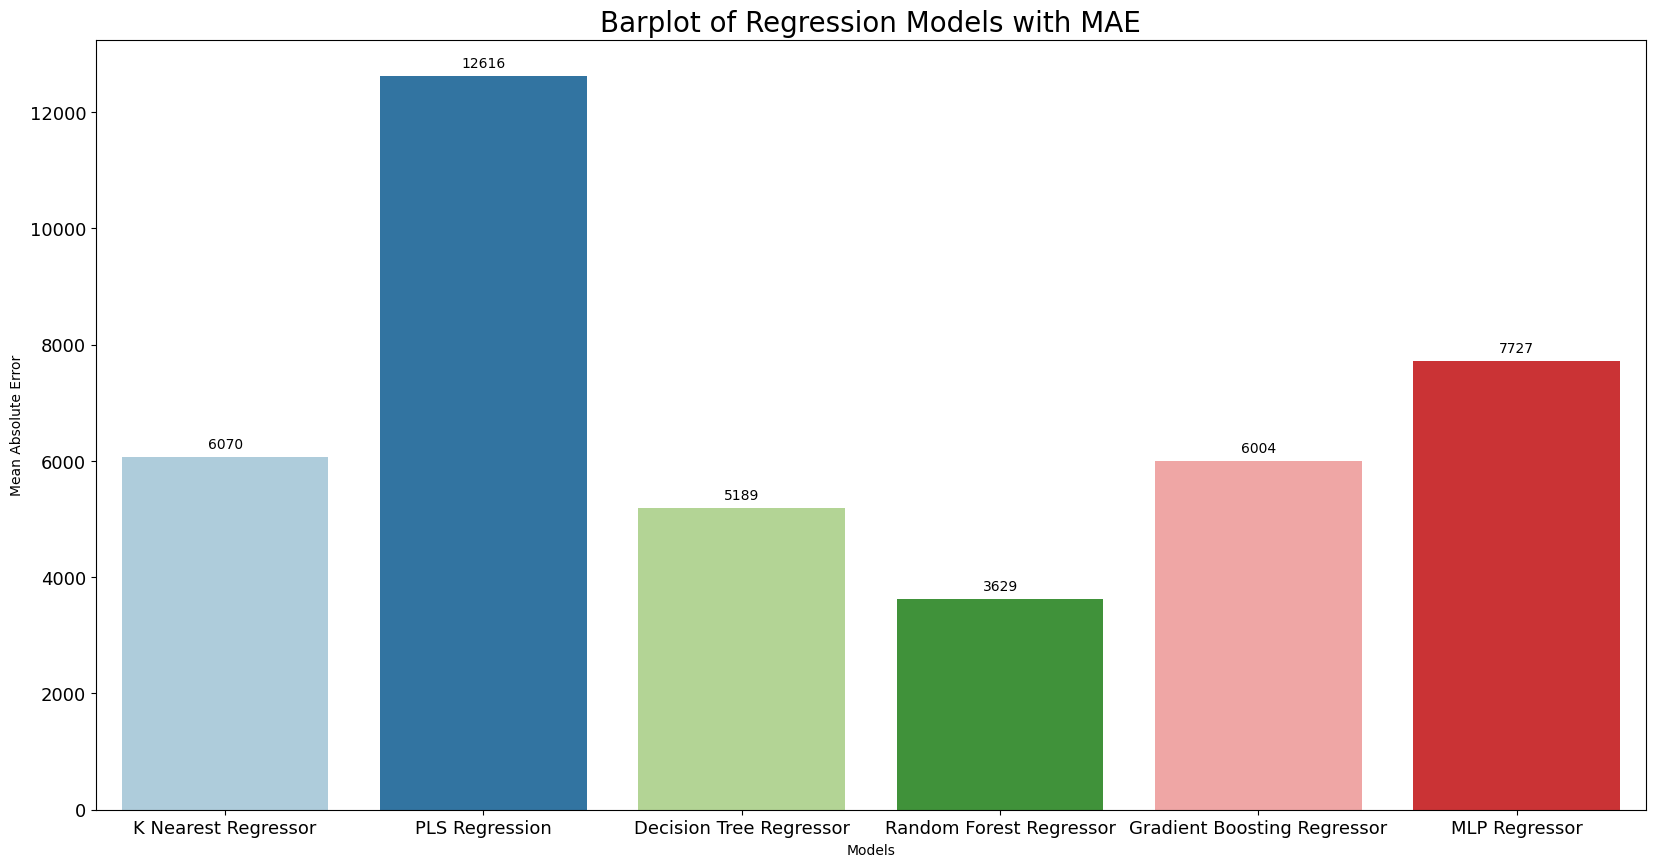

In [89]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Absolute Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MAE", fontsize = 20)
plt.show()

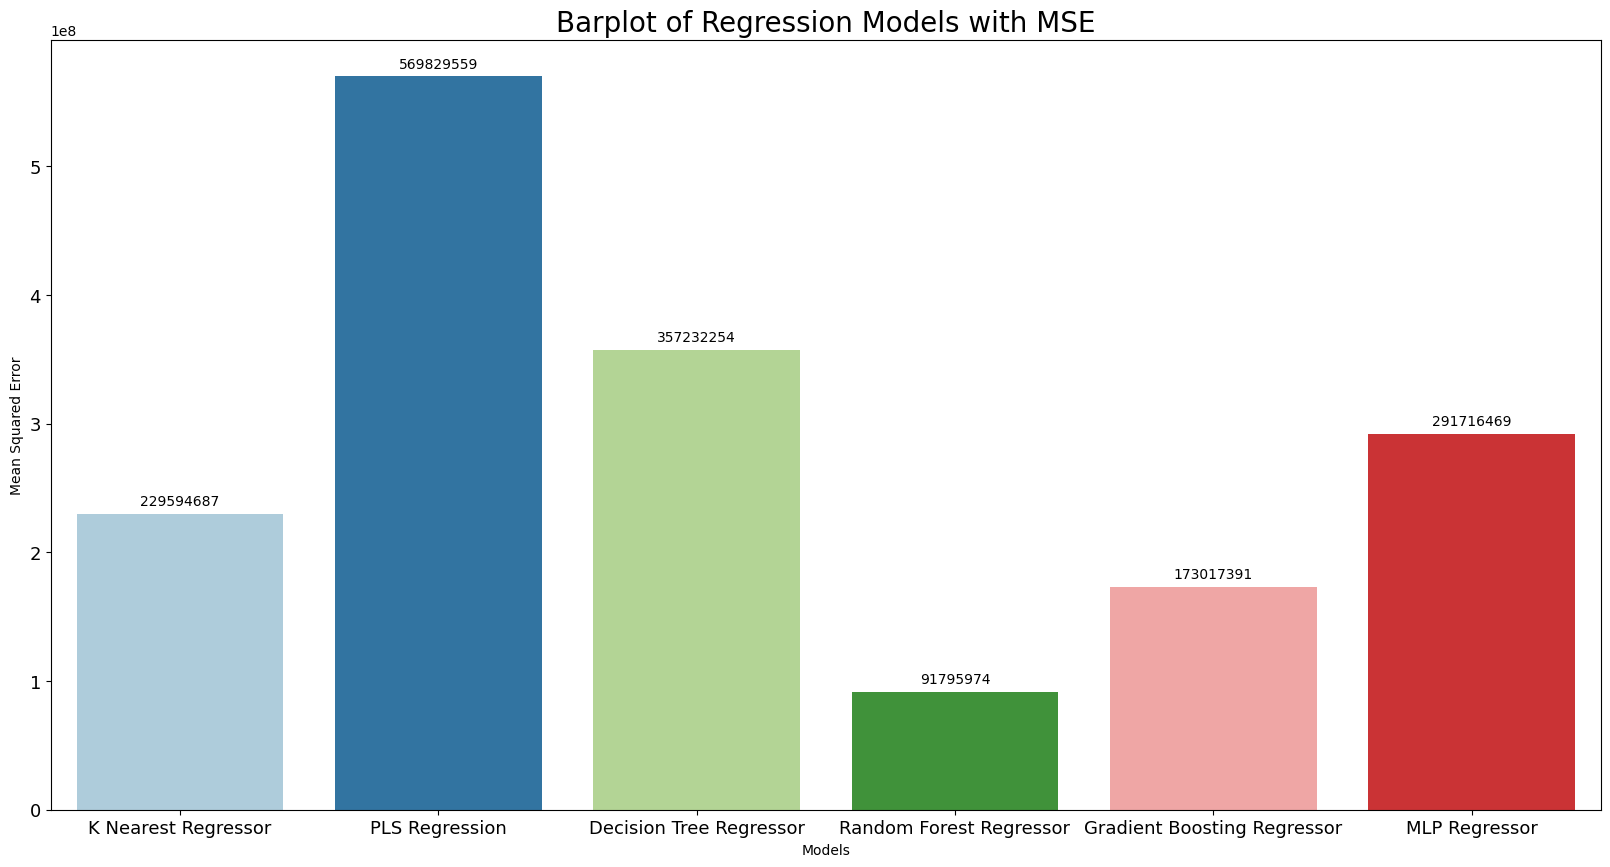

In [90]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Squared Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MSE", fontsize = 20)
plt.show()

# 4b) Random Forest Testing

Use Random Search to narrow down hyperparameter range and then GridSearch to search possible hyperparameter combinations

## Random Search to Narrow Down Hyperparameters

In [94]:
len(X_train.columns)

22

In [95]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
max_features = [int(x) for x in np.linspace(start=1, stop=len(X_train.columns), num=len(X_train.columns)-1)]
min_samples_split = [int(x) for x in np.linspace(start=2, stop=10, num=9)]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=1, n_jobs=5)

In [96]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=50, max_features=20, min_samples_leaf=4, min_samples_split=7, n_estimators=1600; total time= 5.1min
[CV] END bootstrap=False, max_depth=50, max_features=20, min_samples_leaf=4, min_samples_split=7, n_estimators=1600; total time= 5.1min
[CV] END bootstrap=False, max_depth=50, max_features=20, min_samples_leaf=4, min_samples_split=7, n_estimators=1600; total time= 5.1min
[CV] END bootstrap=False, max_depth=50, max_features=20, min_samples_leaf=4, min_samples_split=7, n_estimators=1600; total time= 5.1min
[CV] END bootstrap=False, max_depth=50, max_features=20, min_samples_leaf=4, min_samples_split=7, n_estimators=1600; total time= 5.1min
[CV] END bootstrap=True, max_depth=10, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=  37.4s
[CV] END bootstrap=True, max_depth=10, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total ti

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         22],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [97]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 8,
 'max_depth': 60,
 'bootstrap': False}

In [98]:
base_model = RandomForestRegressor(random_state = 1)
base_model.fit(X_train, y_train)
base_mape = evaluate(base_model, X_test, y_test)

Model Performance
Mean Absolute Error (MAE): 3629.2947
Mean Absolute Percentage Error (MAPE): 0.15


In [103]:
best_random = rf_random.best_estimator_
random_mape = evaluate(best_random, X_test, y_test)

Model Performance
Mean Absolute Error (MAE): 3366.6821
Mean Absolute Percentage Error (MAPE): 0.14


In [102]:
best_params = rf_random.best_params_

In [130]:
for p in best_params:
    print(p , " " , best_params[p])
    

n_estimators   1600
min_samples_split   6
min_samples_leaf   1
max_features   8
max_depth   60
bootstrap   False


Best Model:

n_estimators   1600

min_samples_split   6

min_samples_leaf   1

max_features   8

max_depth   60

bootstrap   False

## Grid Search to Narrow Down Hyperparameters Farther

In [ ]:
param_grid = {
    'n_estimators': [int(best_params['n_estimators'])-100, [int(best_params['n_estimators']), [int(best_params['n_estimators'])+100]]],
    'max_depth': [int(best_params['max_depth'])-5, int(best_params['max_depth']), int(best_params['max_depth'])+5] if best_params['max_depth'] is not None else [None],
    'max_features':[best_params['max_features']],
    'min_samples_split':[int(best_params['min_samples_split']) - 1, int(best_params['min_samples_split']), int(best_params['min_samples_split']) + 1],
    'min_samples_leaf': [int(best_params['min_samples_leaf']) - 1, int(best_params['min_samples_leaf']), int(best_params['min_samples_leaf']) + 1],
    'bootstrap':[best_params['bootstrap']]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=5, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

## Bayesian Optimization

In [ ]:
bayesian_grid = {
    'n_estimators': (50,2000),
    'max_depth': (10,150),
    'min_samples_split':(2,10),
    'min_samples_leaf':(1,8),
    'max_features': (0,1),
    'bootstrap':(0,1)
}

max_features_grid = {
    0:'sqrt',
    1:'log2'
}

bootstrap_grid = {
    0:True,
    1:False
}

In [ ]:
def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap):
    features = max_features_grid[int(max_features)]
    boot = bootstrap_grid[int(bootstrap)]
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  max_features=features,
                                  bootstrap=boot)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return -1.0 * mean_absolute_error(y_test, y_pred)

In [ ]:
optimizer = BayesianOptimization(f=objective, pbounds=bayesian_grid, random_state=1)

In [ ]:
optimizer.maximize(init_points=5, n_iter=15)

In [ ]:
best_params = optimizer.max['params']

In [ ]:
print(best_params)

In [ ]:
features = max_features_grid[int(best_params['max_features'])]
boot = bootstrap_grid[int(best_params['bootstrap'])]
final_model = RandomForestRegressor(n_estimators=int(best_params['n_estimators']),
                                    max_depth=int(best_params['max_depth']),
                                    min_samples_split=int(best_params['min_samples_split']),
                                    min_samples_leaf=int(best_params['min_samples_leaf']),
                                    random_state=1,
                                    max_features=features,
                                    bootstrap=boot)
final_model.fit(X_train, y_train)
score = final_model.score(X_test, y_test)

In [ ]:
evaluate(final_model, X_test, y_test)

# 5) Predict 

In [167]:
new_car = pd.DataFrame({
    'Make':['Audi'],
    'Model':['A8'],
    'Age':['2023'],
    'Trim':['quattro 55 TFSI'],
    'Location':['08550'],
    'Mileage':7800,
    'Color':['Vesuvius Gray Metallic'],
    'Engine_Size':6.0,
    'Gas_Mileage':22,
    'Transmission':['Automatic'],
    'Fuel_Type':['Gas'],
    'Drive_Type':['AWD'],
})

# replace year with age
current_year = datetime.datetime.now().year
new_car['Age'] = current_year - new_car['Age'].astype(int)

# get coordinates from zip code
nomi = pgeocode.Nominatim('us')
location = nomi.query_postal_code(new_car['Location'][0])
new_car['Latitude'] = location.latitude 
new_car['Longitude'] = location.longitude 
new_car = new_car.drop(columns=['Location'])

# target encoding
new_car['Make'] = make_encoder.transform(new_car['Make'])
new_car['Model'] = model_encoder.transform(new_car['Model'])
new_car['Trim'] = trim_encoder.transform(new_car['Trim'])
# new_car['Location'] = location_encoder.transform(new_car['Location'])
new_car['Color'] = color_encoder.transform(new_car['Color'])


# one hot encoding
categorical_features = new_car[['Transmission', 'Fuel_Type', 'Drive_Type']]
one_hot_encoded_new_car = encoder.transform(categorical_features)

one_hot_encoded_new_car_df = pd.DataFrame(one_hot_encoded_new_car, columns=encoder.get_feature_names_out())
new_car = pd.concat([new_car.drop(columns=['Transmission', 'Fuel_Type', 'Drive_Type']), one_hot_encoded_new_car_df], axis=1)



In [148]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
59902,20633.2208,12149.230883,11,18618.443359,77518.0,27395.037391,4.0,25.0,40.5891,-75.4645,...,0,1,0,0,0,0,0,0,0,1


In [168]:
new_car

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
0,51944.155789,43407.036903,1,60609.017517,7800,36003.331175,6.0,22,40.2669,-74.6511,...,0,1,0,0,0,0,0,1,0,0


In [169]:
predicted_price = best_random.predict(new_car)
print(predicted_price)

[67491.45954167]


# 6) Export Required Information

## Export Best Model

In [172]:
with open('model.pkl','wb') as f:
    pickle.dump(best_random, f)

## Export Makes to Models

In [133]:
makes_to_models = data.groupby('Make')['Model'].apply(lambda x: sorted(set(x))).to_dict()

In [134]:
print(makes_to_models)

{'AMC': ['Eagle 30'], 'Acura': ['CL', 'ILX', 'Integra', 'Legend', 'MDX', 'NSX', 'RDX', 'RL', 'RLX', 'RSX', 'SLX', 'TL', 'TLX', 'TSX', 'TSX Sport Wagon', 'ZDX'], 'Alfa Romeo': ['4C', 'GTV6', 'Giulia', 'Spider', 'Stelvio', 'Tonale'], 'Aston Martin': ['DB11', 'DB12', 'DB9', 'DBS', 'DBX', 'Rapide AMR', 'Rapide S', 'V12 Vanquish', 'V12 Vantage', 'V8 Vantage', 'Vanquish', 'Vantage', 'Virage'], 'Audi': ['4000', 'A3', 'A3 Sportback e-tron', 'A4', 'A4 allroad', 'A5', 'A5 Sportback', 'A6', 'A6 allroad', 'A7', 'A8', 'Allroad', 'Cabriolet', 'Q3', 'Q4 e-tron', 'Q4 e-tron Sportback', 'Q5', 'Q5 Hybrid', 'Q5 Sportback', 'Q7', 'Q8', 'Q8 e-tron', 'Q8 e-tron Sportback', 'R8', 'RS 3', 'RS 4', 'RS 5', 'RS 5 Sportback', 'RS 6 Avant', 'RS 7', 'RS Q8', 'RS6', 'S3', 'S4', 'S5', 'S5 Sportback', 'S6', 'S7', 'S8', 'SQ5', 'SQ5 Sportback', 'SQ7', 'SQ8', 'SQ8 e-tron', 'SQ8 e-tron Sportback', 'TT', 'TT RS', 'TTS', 'e-tron', 'e-tron GT', 'e-tron Sportback'], 'BMW': ['1 Series', '2 Series', '3 Series', '4 Series', '5 S

In [135]:
with open('dropdown_info/makes_to_models.json', 'w') as f:
    json.dump(makes_to_models, f, indent=4)

## Export Makes and Models to Trims

In [136]:
makes_models_trims = data.groupby(['Make', 'Model'])['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [137]:
print(makes_models_trims)

{('AMC', 'Eagle 30'): ['Base'], ('Acura', 'CL'): ['2.3 Premium', '3.2', '3.2 Type-S'], ('Acura', 'ILX'): ['2.0L', '2.0L w/Tech', '2.4L w/Premium', '8-Spd AT w/ Premium Package', 'Base', 'Premium & A-SPEC Packages', 'Premium Package', 'Premium Pkg Sedan 4D', 'Sedan 4D', 'Standard', 'Technology & A-SPEC Pkgs Sedan 4D', 'Technology Package', 'Technology Pkg Sedan 4D', 'Technology/A-Spec Package', 'w/Premium', 'w/Premium/A-SPEC Package', 'w/Premium/A-SPEC Pkg', 'w/Special Edition', 'w/Tech', 'w/Technology/A-SPEC Package', 'with Premium and A-Spec Package'], ('Acura', 'Integra'): ['Base', 'Type S', 'w/A-SPEC', 'w/Tech w/A-SPEC'], ('Acura', 'Legend'): ['Base', 'GS', 'L'], ('Acura', 'MDX'): ['Base', 'SH-AWD', 'SH-AWD Sport Utility 4D', 'SH-AWD w/A-SPEC', 'SH-AWD w/Advance', 'SH-AWD w/Advance w/RES', 'SH-AWD w/Power Tailgate w/Tech', 'SH-AWD w/Tech', 'SH-AWD w/Tech w/RES', 'Technology Package', 'Touring w/Navi w/RES', 'w/Tech'], ('Acura', 'NSX'): ['Base', 'NSX-T', 'SH-AWD Sport Hybrid', 'SH-AW

In [138]:
json_compatible = {f"{make}_{model}": trims for (make, model), trims in makes_models_trims.items()}

In [139]:
with open('dropdown_info/makes_models_to_trims.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

## Export Makes and Models to Colors

In [140]:
makes_models_colors = data.groupby(['Make', 'Model'])['Color'].apply(lambda x: sorted(set(x))).to_dict()

In [141]:
print(makes_models_colors)

{('AMC', 'Eagle 30'): ['Brown'], ('Acura', 'CL'): ['Black', 'Naples Gold Metallic', 'Red', 'San Marino Red', 'White'], ('Acura', 'ILX'): ['Apex Blue Pearl', 'Basque Red Pearl Ii', 'Bellanova White Pearl', 'Black', 'Blue', 'Burgundy', 'Crystal Black Pearl', 'Gray', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Modern Steel Metallic', 'Pearl White', 'Performance Red Pearl', 'Platinum White Pearl', 'Polished Metal Metallic', 'Silver', 'Slate Silver Metallic', 'Unknown', 'Whi', 'White', 'nan'], ('Acura', 'Integra'): ['Apex Blue Pearl', 'Black', 'Gray', 'Green', 'Liquid Carbon Metallic', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Performance Red Pearl', 'Platinum White Pearl', 'Silver', 'Unknown', 'nan'], ('Acura', 'Legend'): ['Charcoal', 'Gold', 'Green', 'White'], ('Acura', 'MDX'): ['Aspen White Pearl', 'Billet Silver Metallic', 'Black', 'Blue', 'Brown', 'Burgundy', 'Crystal Black Pearl', 'Fathom Blue Pearl', 'Graphite Luster Metallic', 'Gray', 'Grigio Metallic', 'Gunmetal Metal

In [142]:
json_compatible = {f"{make}_{model}": colors for (make, model), colors in makes_models_colors.items()}

In [143]:
with open('dropdown_info/makes_models_to_colors.json', 'w') as f:
    json.dump(json_compatible, f, indent=4)

## Export Encoders

In [173]:
with open('encoders/make_encoder.pkl', 'wb') as f:
    pickle.dump(make_encoder, f)

with open('encoders/model_encoder.pkl', 'wb') as f:
    pickle.dump(model_encoder, f)

with open('encoders/trim_encoder.pkl', 'wb') as f:
    pickle.dump(trim_encoder, f)

with open('encoders/color_encoder.pkl', 'wb') as f:
    pickle.dump(color_encoder, f)

with open('encoders/onehotencoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)